# <font color="red">Conditions Prediction with Support Vector Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

import sys
#sys.path.append('../../') # Uncomment this line if running locally
sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
#weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Parameters

In [8]:
grid_param = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'coef0': [0.0, 0.1, 1.0],
    'shrinking': [True],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

In [9]:
number_of_model_for_randomized_grid = 130
model_name_for_saving = "SVC"
target_name_for_saving = "Conditions"
number_of_model_for_bagging = 100

# All Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Conditions']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Conditions']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## MinMax Scaler

In [14]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [15]:
X_train

array([[0.81818182, 0.46666667, 0.69565217, ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.16666667, 0.86956522, ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.3       , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.83333333, 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.53333333, 0.34782609, ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.8       , 0.65217391, ..., 0.8155    , 0.542     ,
        0.07388643]])

In [16]:
X_test

array([[0.18181818, 0.4       , 0.52173913, ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 0.06666667, 1.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.56666667, 0.73913043, ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.76666667, 0.82608696, ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.43333333, 0.86956522, ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.66666667, 0.26086957, ..., 0.4901    , 0.        ,
        0.99324467]])

### Default Parameters

In [17]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [18]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 8.59 s, sys: 306 ms, total: 8.9 s
Wall time: 8.89 s


SVC(probability=True, random_state=42)

In [19]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [20]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [21]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [22]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9405
Precision: 0.9440
Recall:    0.9405
F1-Score:  0.9280


In [23]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.96      0.98       663
              Overcast       1.00      0.19      0.32       126
      Partially cloudy       0.92      1.00      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       1.00      0.73      0.84       149
Rain, Partially cloudy       0.91      1.00      0.95       424

              accuracy                           0.94      2924
             macro avg       0.80      0.65      0.68      2924
          weighted avg       0.94      0.94      0.93      2924



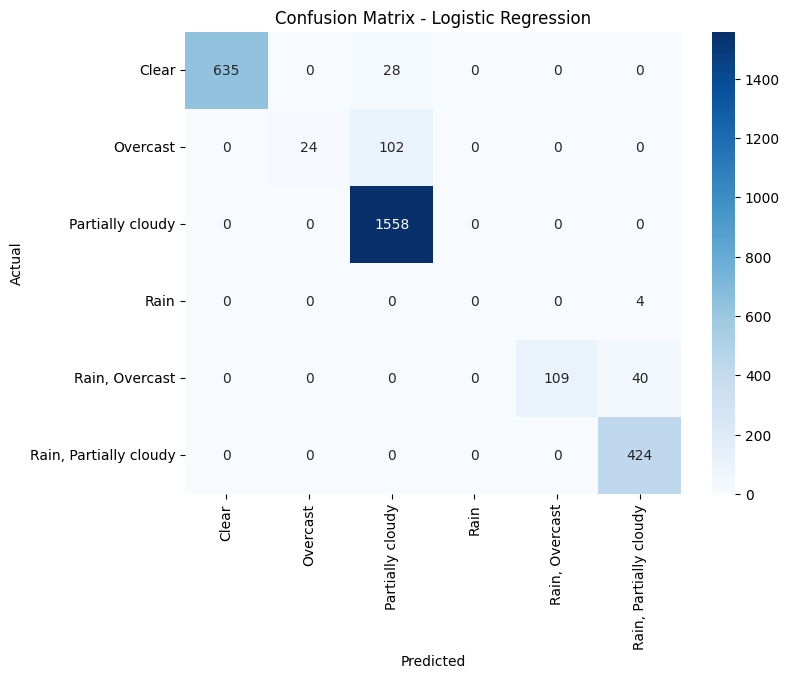

In [24]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [26]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9975
Partially cloudy : 0.9983
Rain     : 0.9995
Rain, Overcast : 0.9966
Rain, Partially cloudy : 0.9985
Micro-avg : 0.9991


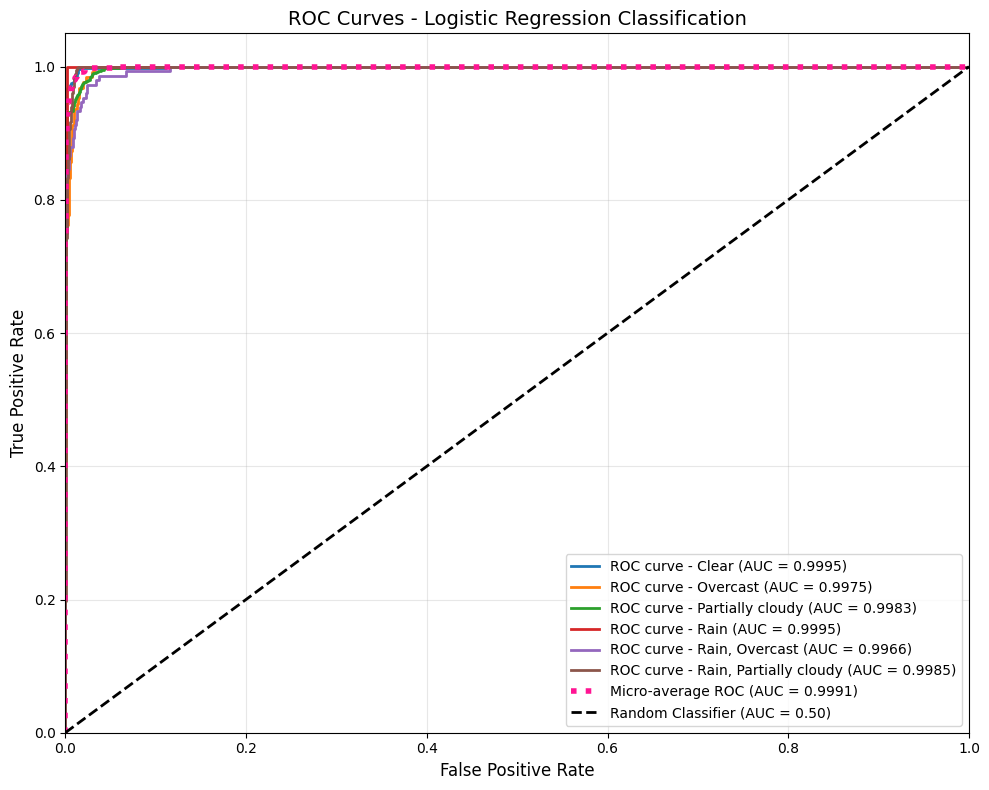

In [28]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9985
One-vs-One (Weighted)  : 0.9970
Micro-average          : 0.9991


In [30]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.940492, F1: 0.928046, AUC (micro-avg): 0.999127
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [31]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [32]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 28 s, sys: 8.88 s, total: 36.8 s
Wall time: 1h 29min 37s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [33]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best parameters as an array
grid_param_minmax = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9898825143098071


In [34]:
y_pred_grid = best_grid_model.predict(X_test)

In [35]:
y_pred_grid

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [36]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [37]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [38]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9880
Precision: 0.9881
Recall:    0.9880
F1-Score:  0.9879


In [39]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.97      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       1.00      0.50      0.67         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       0.99      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.99      0.91      0.94      2924
          weighted avg       0.99      0.99      0.99      2924



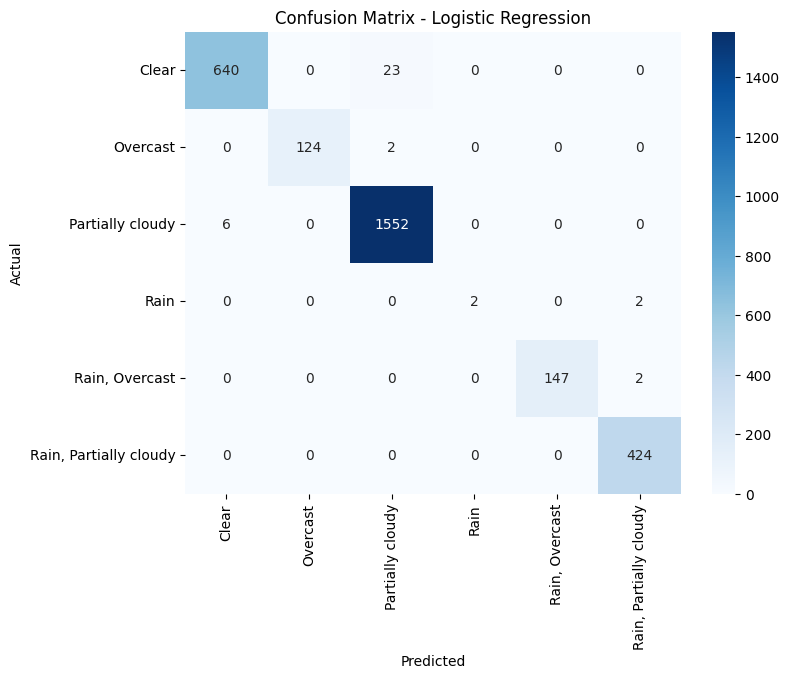

In [40]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [42]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [43]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9996
Overcast : 0.9954
Partially cloudy : 0.9994
Rain     : 0.9994
Rain, Overcast : 0.9932
Rain, Partially cloudy : 0.9995
Micro-avg : 0.9992


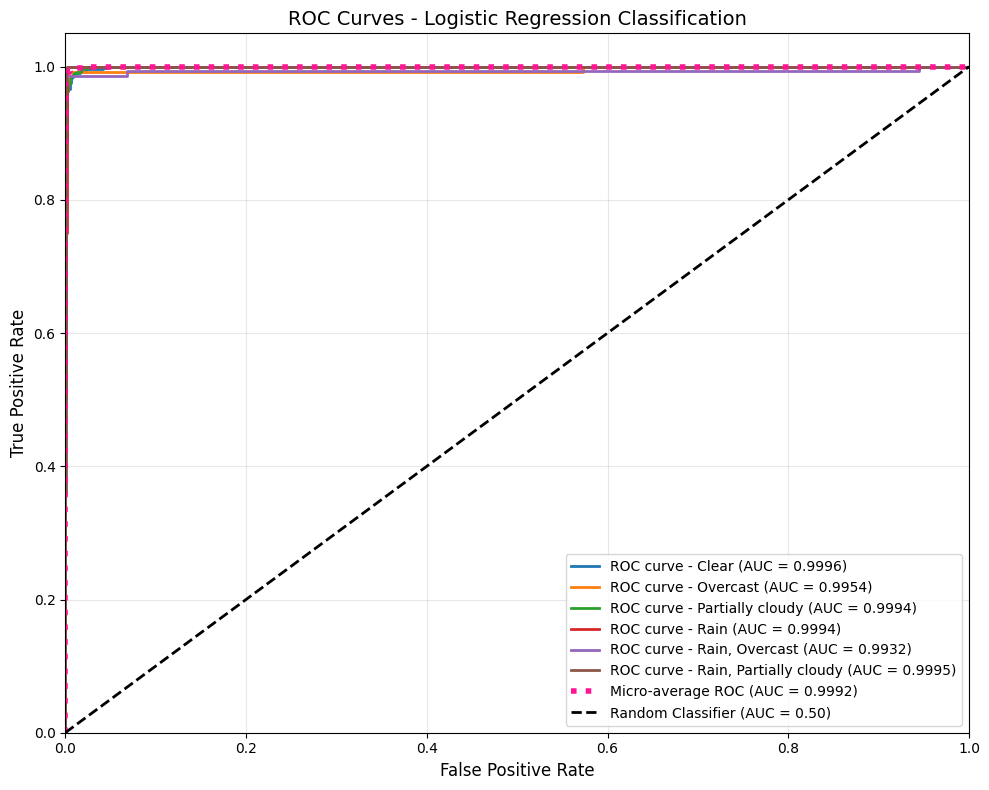

In [44]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9990
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9992


In [46]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.988030, F1: 0.987882, AUC (micro-avg): 0.999221
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [47]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [48]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [49]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  5.4min remaining:  5.4min


CPU times: user 1.51 s, sys: 720 ms, total: 2.23 s
Wall time: 5min 53s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  5.9min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [50]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.2s remaining:   30.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.2s finished


In [51]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [52]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9767
Precision: 0.9773
Recall:    0.9767
F1-Score:  0.9762


In [53]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.83      0.90       126
      Partially cloudy       0.97      1.00      0.98      1558
                  Rain       1.00      0.50      0.67         4
        Rain, Overcast       1.00      0.91      0.95       149
Rain, Partially cloudy       0.97      1.00      0.98       424

              accuracy                           0.98      2924
             macro avg       0.99      0.87      0.91      2924
          weighted avg       0.98      0.98      0.98      2924



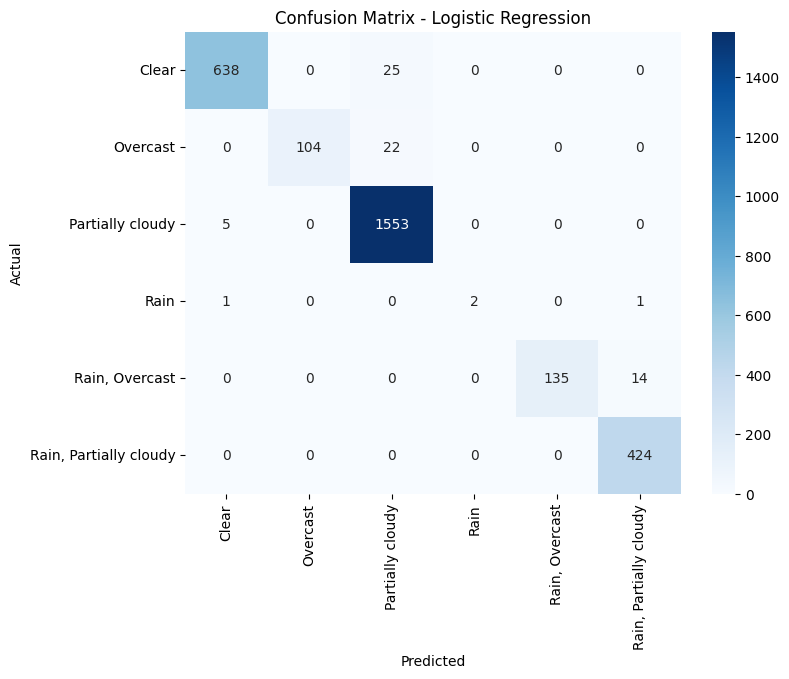

In [54]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [55]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.9s remaining:   30.9s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   32.6s finished


In [56]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [57]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9988
Overcast : 0.9996
Partially cloudy : 0.9982
Rain     : 0.9997
Rain, Overcast : 0.9972
Rain, Partially cloudy : 0.9992
Micro-avg : 0.9986


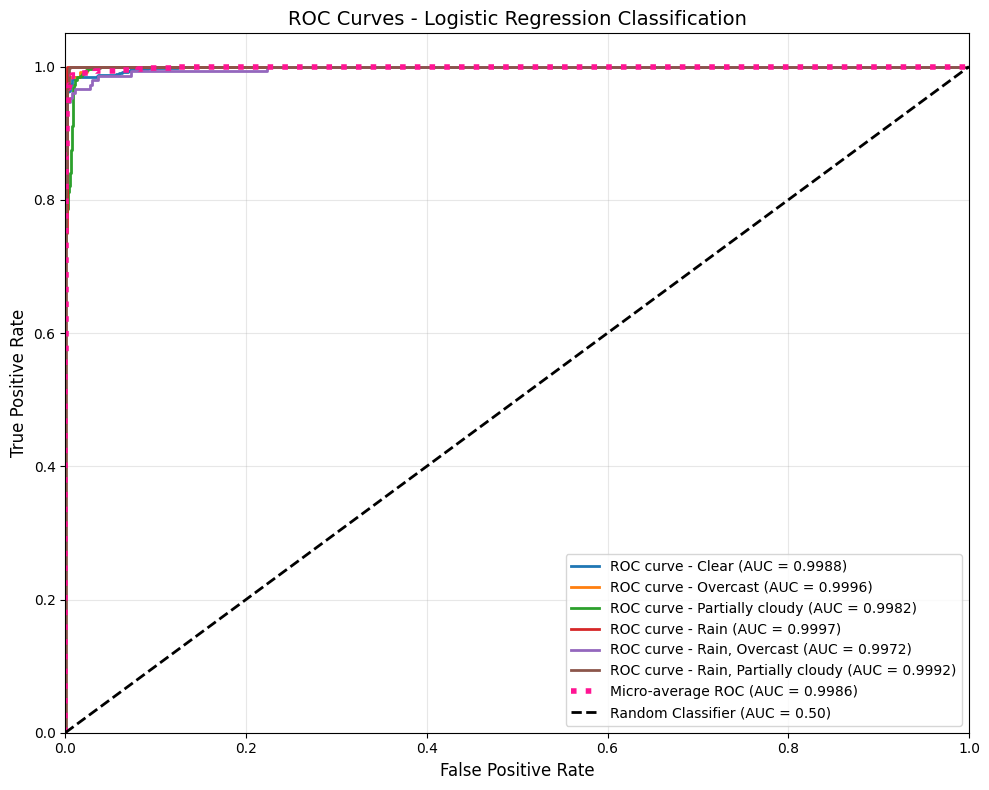

In [58]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [59]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9985
One-vs-One (Weighted)  : 0.9982
Micro-average          : 0.9986


In [60]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.976744, F1: 0.976238, AUC (micro-avg): 0.998589
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [62]:
X_train

array([[ 1.34459066, -0.08798128,  0.64443839, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082, -1.10860676,  1.22392493, ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -0.65499543, -1.67350776, ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082,  1.15944987, -1.67350776, ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 ,  0.13882439, -0.51453468, ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  1.04604704,  0.49956676, ...,  0.79539807,
         1.00886284, -0.43437432]])

In [63]:
X_test

array([[-0.8453494 , -0.31478694,  0.06495186, ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208, -1.44881525,  1.65853984, ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.25222722,  0.78931003, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  0.9326442 ,  1.0790533 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208, -0.20138411,  1.22392493, ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082,  0.59243571, -0.80427795, ..., -0.12954086,
        -0.74169989,  5.41145777]])

### Default Parameters

In [64]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [65]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 11.8 s, sys: 0 ns, total: 11.8 s
Wall time: 11.8 s


SVC(probability=True, random_state=42)

In [66]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [67]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [68]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [69]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9374
Precision: 0.9398
Recall:    0.9374
F1-Score:  0.9251


In [70]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.96      0.98       663
              Overcast       1.00      0.20      0.33       126
      Partially cloudy       0.93      1.00      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.94      0.70      0.80       149
Rain, Partially cloudy       0.89      0.98      0.94       424

              accuracy                           0.94      2924
             macro avg       0.79      0.64      0.67      2924
          weighted avg       0.94      0.94      0.93      2924



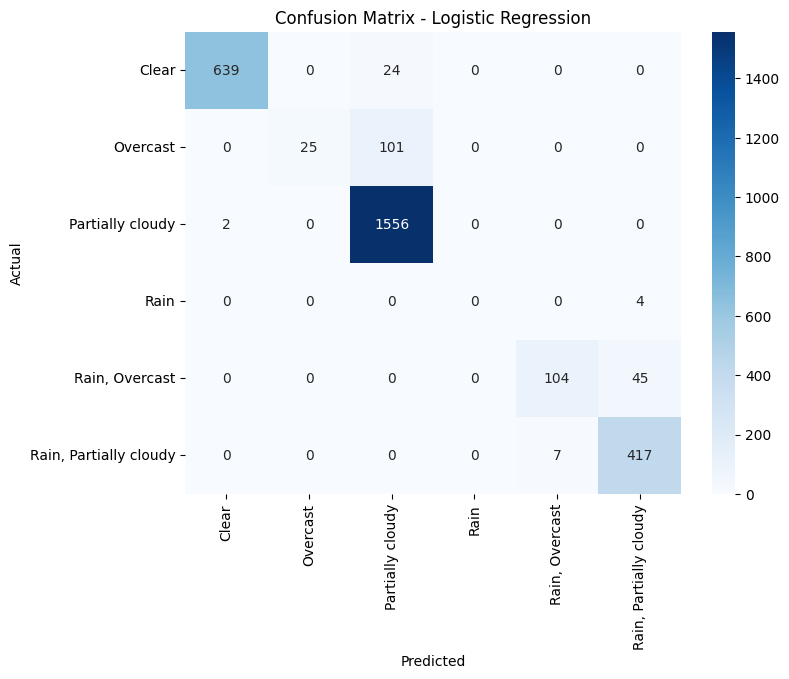

In [71]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [73]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [74]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9994
Overcast : 0.9906
Partially cloudy : 0.9963
Rain     : 0.9976
Rain, Overcast : 0.9927
Rain, Partially cloudy : 0.9968
Micro-avg : 0.9982


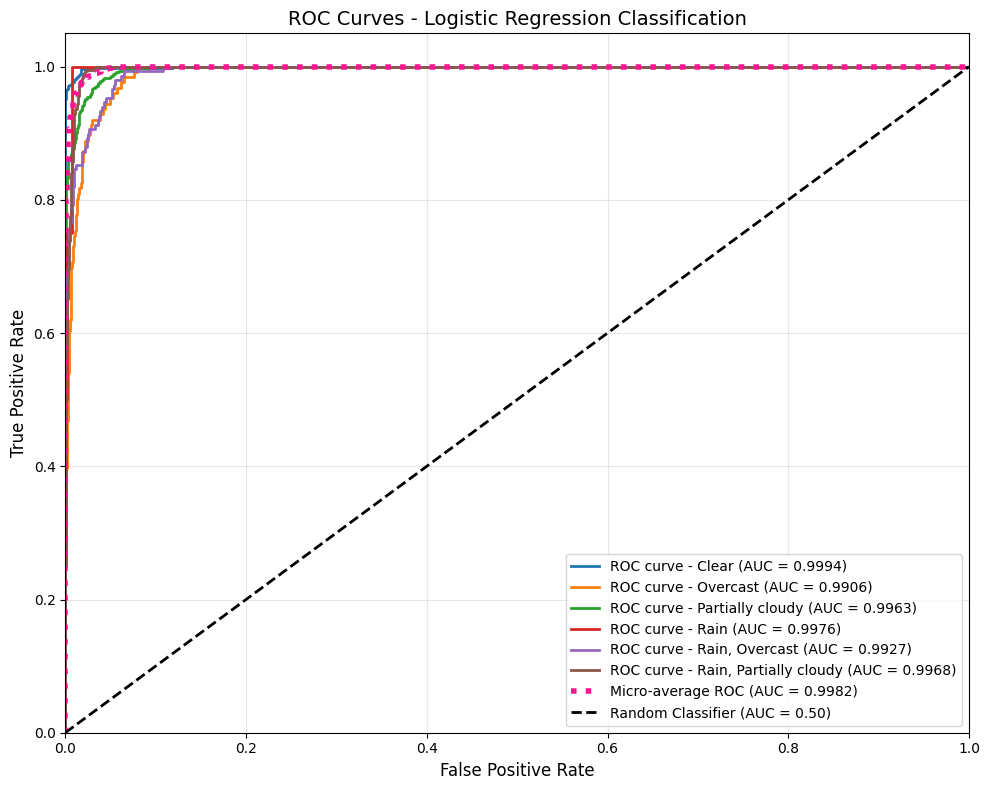

In [75]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [76]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9967
One-vs-One (Weighted)  : 0.9928
Micro-average          : 0.9982


In [77]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.937415, F1: 0.925080, AUC (micro-avg): 0.998191
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [78]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [79]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 42.8 s, sys: 8.07 s, total: 50.9 s
Wall time: 1h 17min 54s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [80]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to train the robust scaler model
grid_param_standard = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9900433999403985


In [81]:
y_pred_grid = best_grid_model.predict(X_test)

In [82]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [83]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9880
Precision: 0.9881
Recall:    0.9880
F1-Score:  0.9879


In [84]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.97      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       1.00      0.50      0.67         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       0.99      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.99      0.91      0.94      2924
          weighted avg       0.99      0.99      0.99      2924



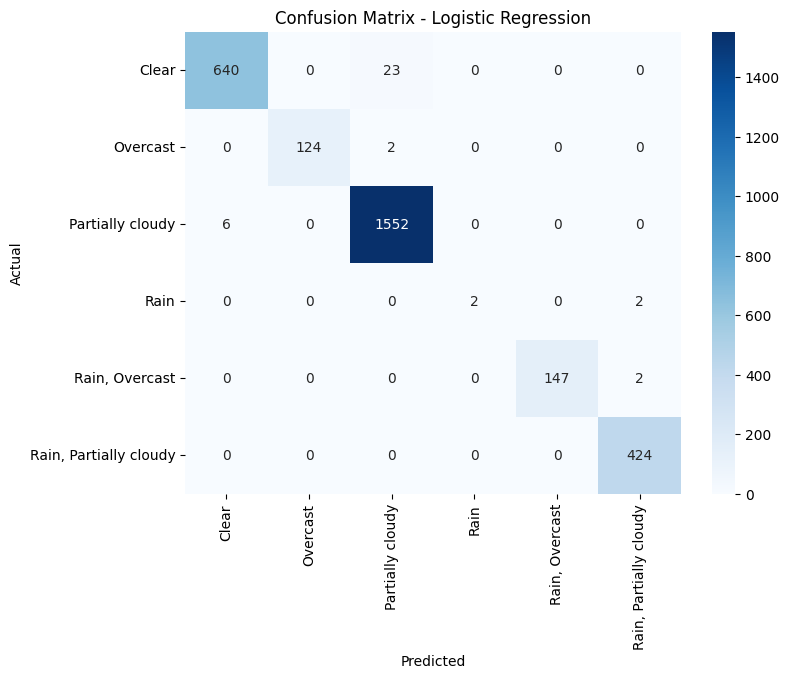

In [85]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [86]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [87]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [88]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9961
Partially cloudy : 0.9994
Rain     : 0.9992
Rain, Overcast : 0.9932
Rain, Partially cloudy : 0.9995
Micro-avg : 0.9993


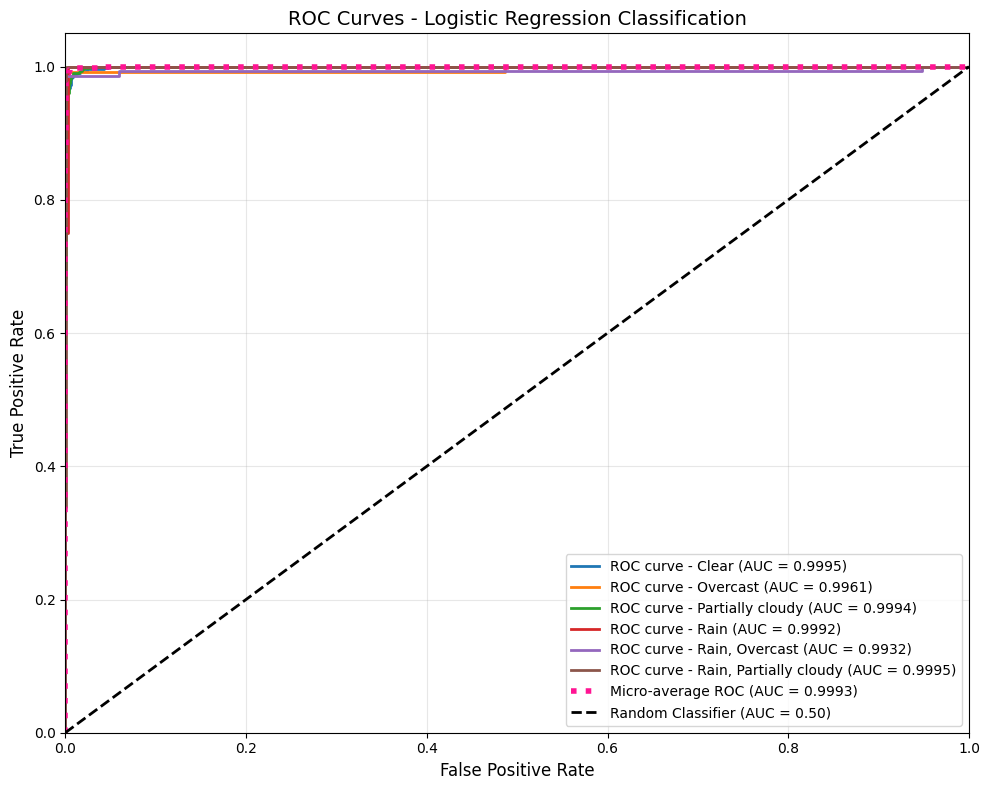

In [89]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [90]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9990
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9993


In [91]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.988030, F1: 0.987882, AUC (micro-avg): 0.999295
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [92]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [93]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [94]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  5.4min remaining:  5.4min


CPU times: user 2.12 s, sys: 21.5 ms, total: 2.14 s
Wall time: 5min 50s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  5.8min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [95]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.5s remaining:   30.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   31.9s finished


In [96]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [97]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9651
Precision: 0.9663
Recall:    0.9651
F1-Score:  0.9634


In [98]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.69      0.82       126
      Partially cloudy       0.96      1.00      0.98      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       0.98      0.81      0.89       149
Rain, Partially cloudy       0.93      1.00      0.96       424

              accuracy                           0.97      2924
             macro avg       0.98      0.78      0.84      2924
          weighted avg       0.97      0.97      0.96      2924



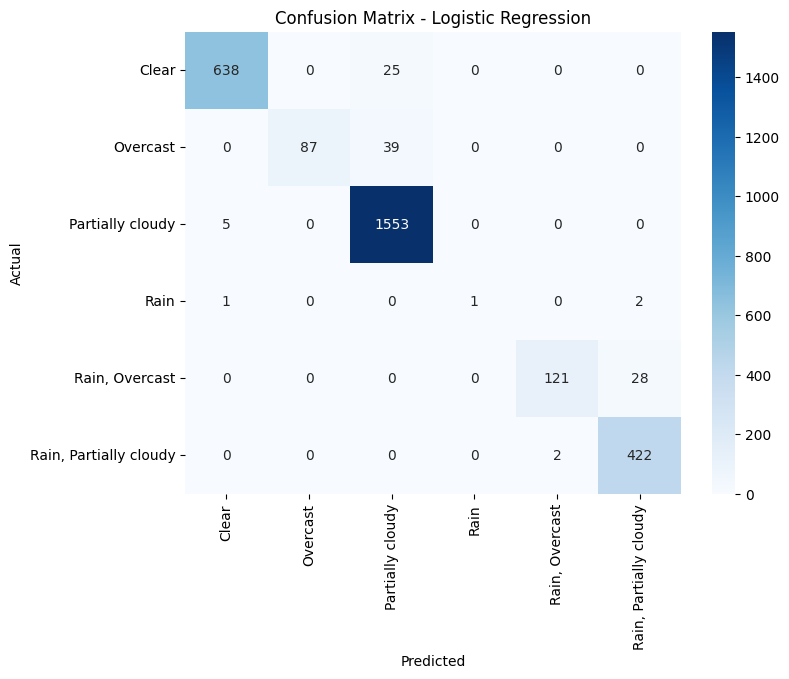

In [99]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [100]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.2s remaining:   30.2s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   32.3s finished


In [101]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [102]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9987
Overcast : 0.9990
Partially cloudy : 0.9978
Rain     : 0.9995
Rain, Overcast : 0.9961
Rain, Partially cloudy : 0.9984
Micro-avg : 0.9983


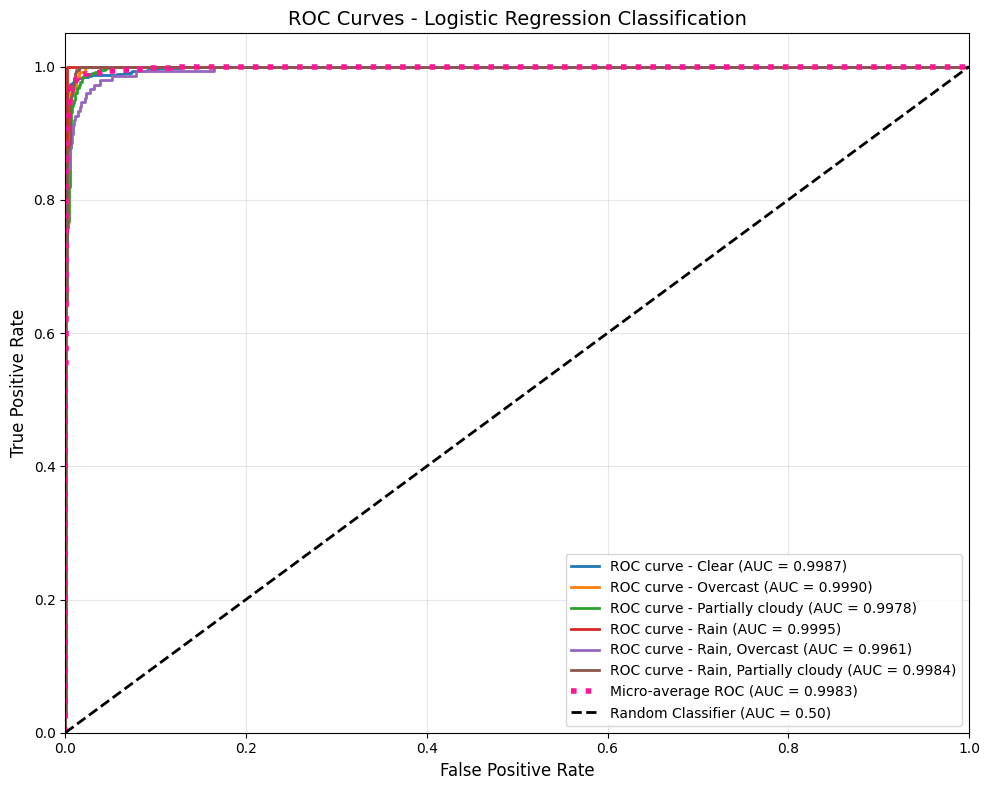

In [103]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9981
One-vs-One (Weighted)  : 0.9972
Micro-average          : 0.9983


In [105]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.965116, F1: 0.963414, AUC (micro-avg): 0.998304
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [106]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [107]:
X_train

array([[ 1.00000000e+00, -6.66666667e-02,  3.33333333e-01, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01, -6.66666667e-01,  6.66666667e-01, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -4.00000000e-01, -1.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01,  6.66666667e-01, -1.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01,  6.66666667e-02, -3.33333333e-01, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  6.00000000e-01,  2.50000000e-01, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]])

In [108]:
X_test

array([[-0.4       , -0.2       ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       , -0.86666667,  0.91666667, ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.13333333,  0.41666667, ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.53333333,  0.58333333, ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       , -0.13333333,  0.66666667, ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       ,  0.33333333, -0.5       , ..., -0.04159162,
         0.        , 33.75968992]])

### Default Parameters

In [109]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [110]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 25.6 s, sys: 351 ms, total: 26 s
Wall time: 26 s


SVC(probability=True, random_state=42)

In [111]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [112]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [113]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [114]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6860
Precision: 0.7166
Recall:    0.6860
F1-Score:  0.5754


In [115]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.04      0.08       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.67      1.00      0.80      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.47      0.10      0.17       149
Rain, Partially cloudy       0.75      0.96      0.84       424

              accuracy                           0.69      2924
             macro avg       0.48      0.35      0.31      2924
          weighted avg       0.72      0.69      0.58      2924



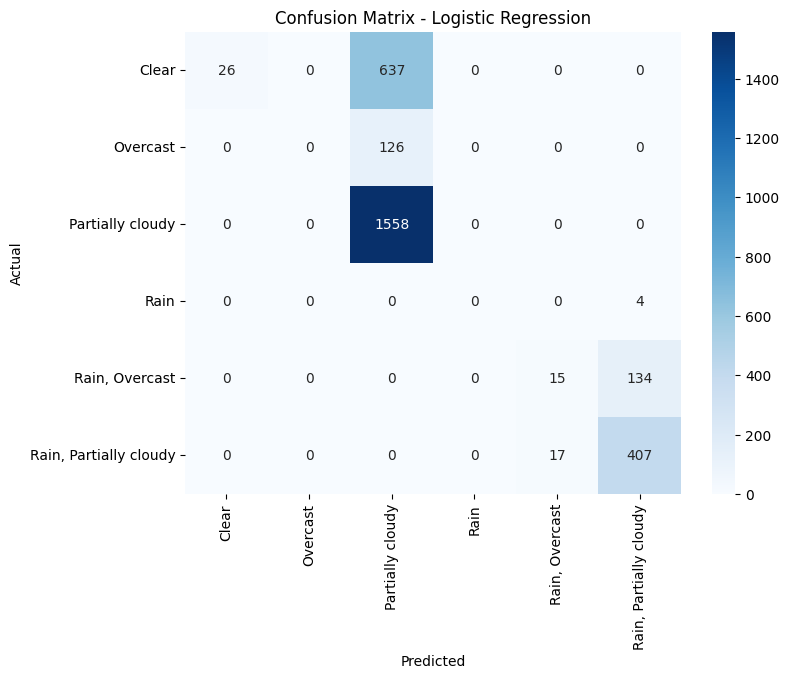

In [116]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [117]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [118]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [119]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9728
Overcast : 0.9990
Partially cloudy : 0.9766
Rain     : 0.9931
Rain, Overcast : 0.9737
Rain, Partially cloudy : 0.9792
Micro-avg : 0.9872


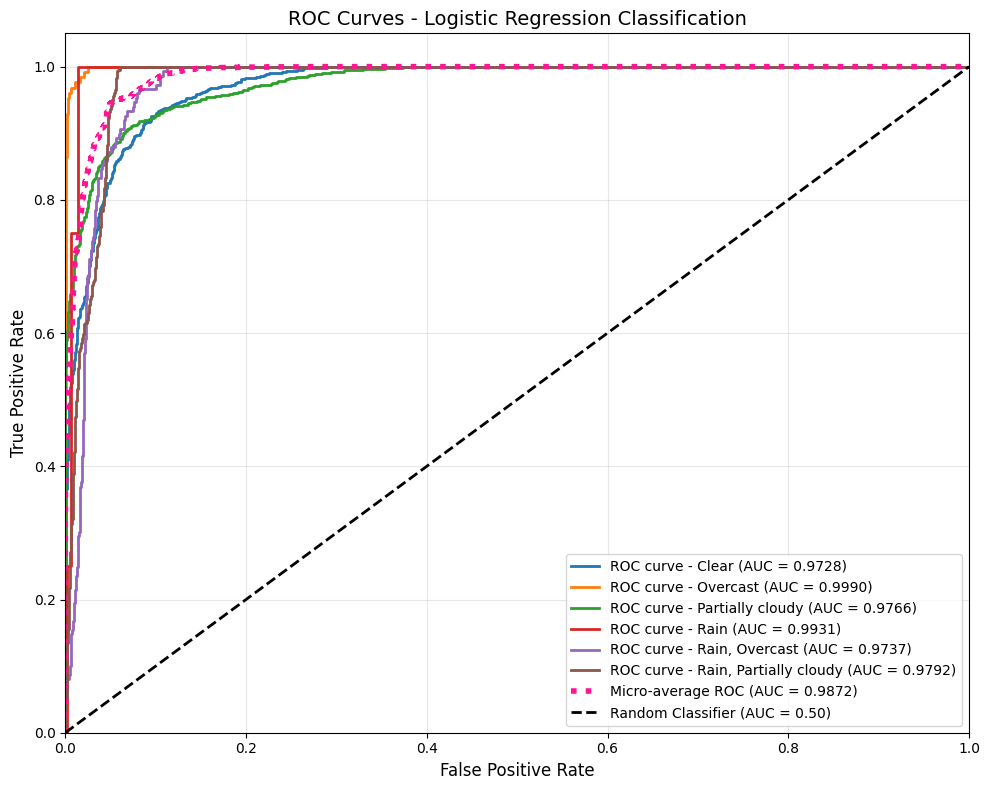

In [120]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [121]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9770
One-vs-One (Weighted)  : 0.9697
Micro-average          : 0.9872


In [122]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.686047, F1: 0.575394, AUC (micro-avg): 0.987153
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [123]:
grid_param_robust = [grid_param_minmax, grid_param_standard]

In [124]:
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param_robust,
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, # allow parallel processing, you cant use your own laptop while this runs
    verbose=1,
    return_train_score=True
)

grid_search

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [125]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 22min 1s, sys: 12.5 s, total: 22min 13s
Wall time: 2h 54min 57s


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'C': 100, 'class_weight': None, 'coef0': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.9873401261905969


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9860
Precision: 0.9861
Recall:    0.9860
F1-Score:  0.9858


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.97      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       1.00      0.50      0.67         4
        Rain, Overcast       0.99      0.95      0.97       149
Rain, Partially cloudy       0.98      1.00      0.99       424

              accuracy                           0.99      2924
             macro avg       0.99      0.90      0.93      2924
          weighted avg       0.99      0.99      0.99      2924



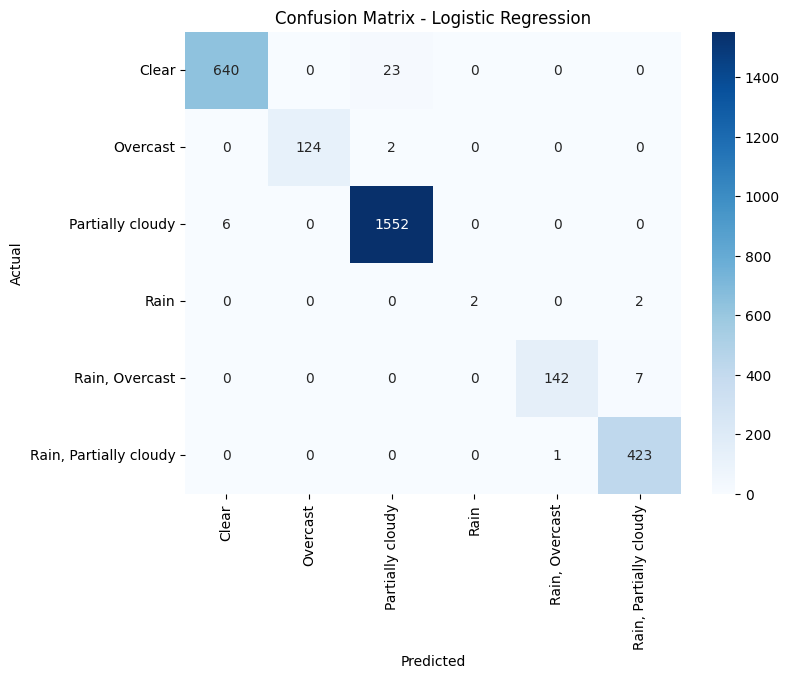

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9957
Partially cloudy : 0.9994
Rain     : 0.9969
Rain, Overcast : 0.9793
Rain, Partially cloudy : 0.9993
Micro-avg : 0.9984


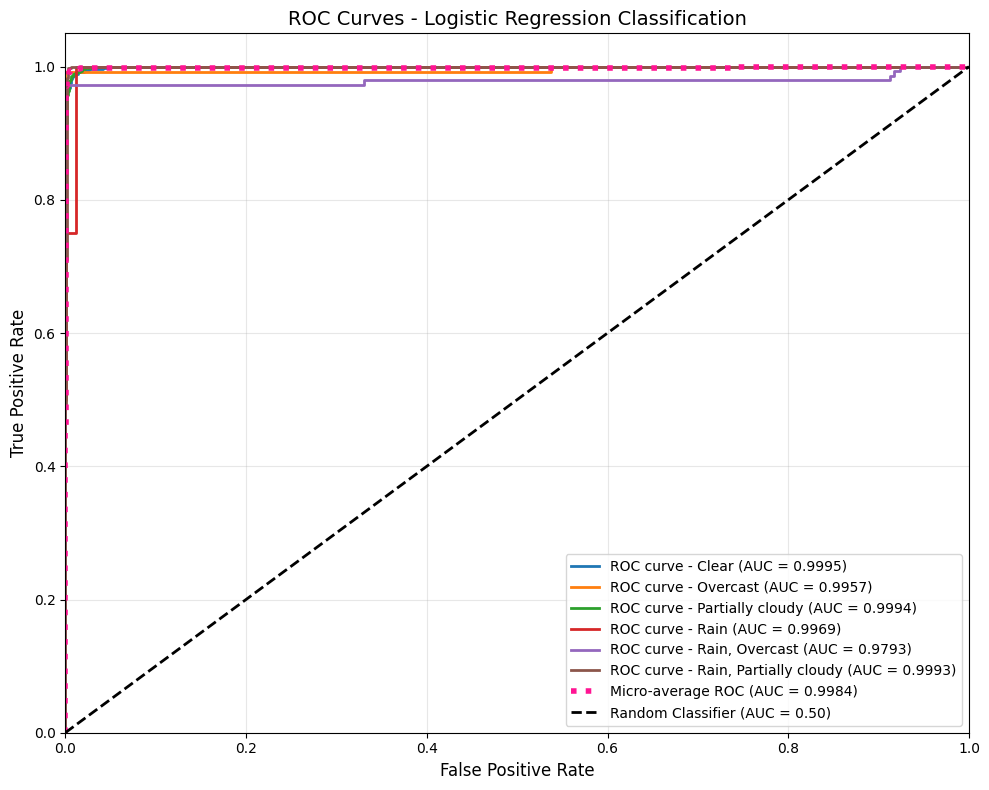

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9982
One-vs-One (Weighted)  : 0.9957
Micro-average          : 0.9984


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.985978, F1: 0.985817, AUC (micro-avg): 0.998376
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [140]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  7.1min remaining:  7.1min


CPU times: user 2.85 s, sys: 0 ns, total: 2.85 s
Wall time: 7min 12s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  7.2min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   43.4s remaining:   43.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   44.4s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9166
Precision: 0.9229
Recall:    0.9166
F1-Score:  0.9051


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.91      0.95      0.93       663
              Overcast       1.00      0.82      0.90       126
      Partially cloudy       0.96      0.96      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.94      0.20      0.33       149
Rain, Partially cloudy       0.77      1.00      0.87       424

              accuracy                           0.92      2924
             macro avg       0.76      0.65      0.67      2924
          weighted avg       0.92      0.92      0.91      2924



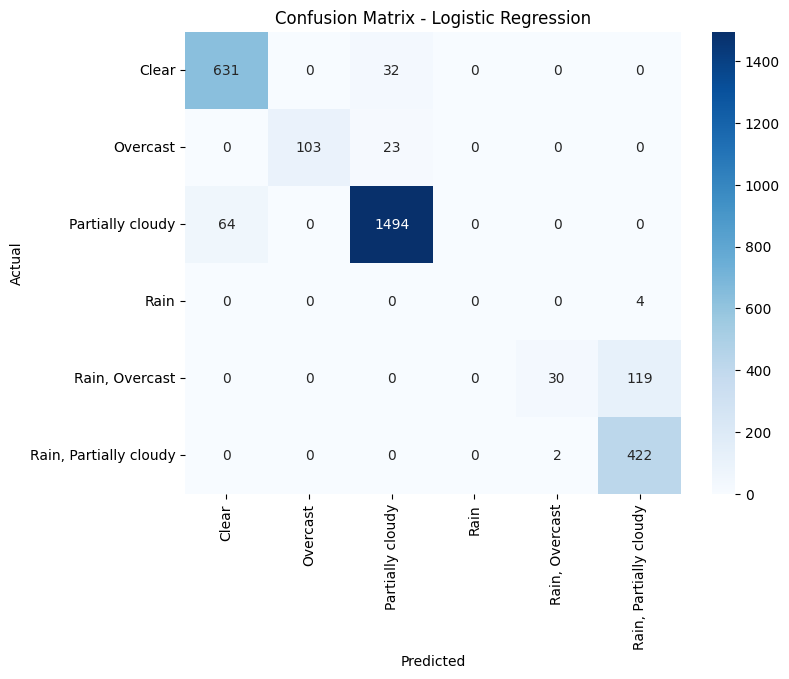

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   43.4s remaining:   43.4s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   44.0s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9942
Overcast : 0.9997
Partially cloudy : 0.9936
Rain     : 0.9995
Rain, Overcast : 0.9868
Rain, Partially cloudy : 0.9920
Micro-avg : 0.9954


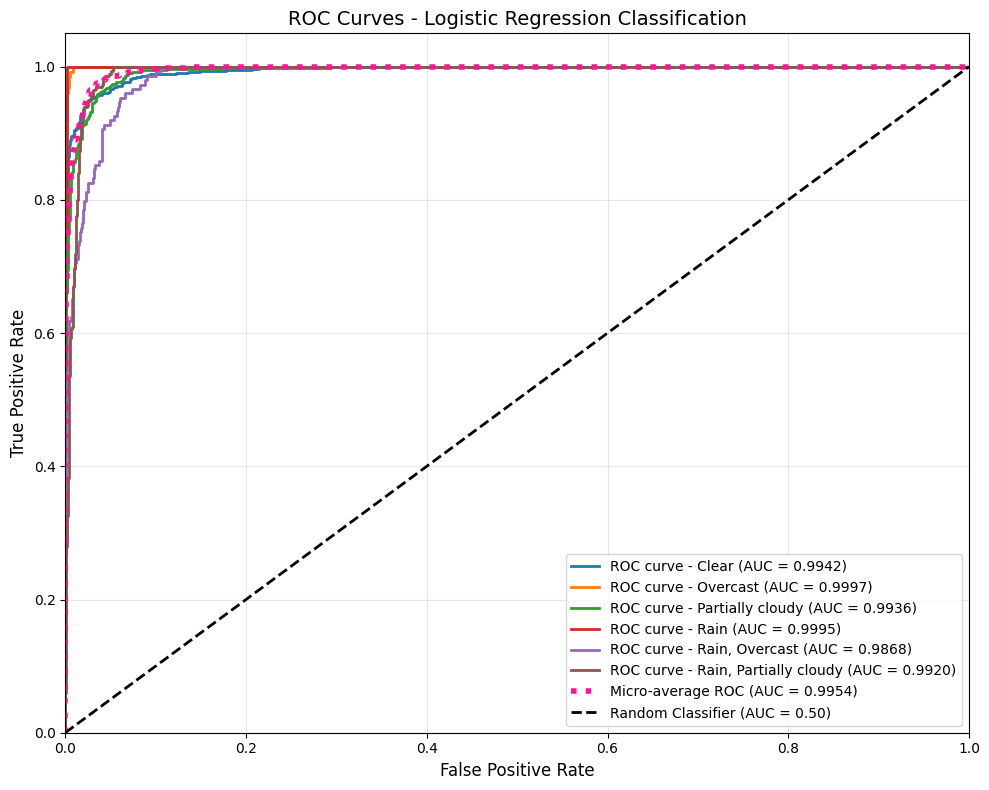

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9934
One-vs-One (Weighted)  : 0.9910
Micro-average          : 0.9954


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.916553, F1: 0.905096, AUC (micro-avg): 0.995382
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [158]:
X_train

array([[0.81818182, 0.69565217, 1.        , ..., 0.4906    , 0.319     ,
        0.08950813],
       [0.27272727, 0.86956522, 0.        , ..., 0.5161    , 0.        ,
        0.68439941],
       [1.        , 0.        , 0.        , ..., 0.3604    , 0.        ,
        0.07388643],
       ...,
       [0.27272727, 0.        , 0.        , ..., 0.2311    , 0.        ,
        0.07388643],
       [0.18181818, 0.34782609, 0.        , ..., 0.8811    , 0.197     ,
        0.0204771 ],
       [0.18181818, 0.65217391, 1.        , ..., 0.8155    , 0.542     ,
        0.07388643]])

In [159]:
X_test

array([[0.18181818, 0.52173913, 0.        , ..., 0.2298    , 0.9       ,
        0.07388643],
       [0.72727273, 1.        , 0.        , ..., 0.8872    , 0.        ,
        0.08074731],
       [0.45454545, 0.73913043, 1.        , ..., 0.8894    , 0.206     ,
        0.58465273],
       ...,
       [0.27272727, 0.82608696, 0.        , ..., 0.8816    , 0.        ,
        0.06195905],
       [0.72727273, 0.86956522, 0.        , ..., 0.8825    , 0.        ,
        0.09436352],
       [0.27272727, 0.26086957, 0.        , ..., 0.4901    , 0.        ,
        0.99324467]])

#### Default Parameters

In [160]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [161]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 7.22 s, sys: 0 ns, total: 7.22 s
Wall time: 7.23 s


SVC(probability=True, random_state=42)

In [162]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [163]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9425
Precision: 0.9457
Recall:    0.9425
F1-Score:  0.9311


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.96      0.98       663
              Overcast       1.00      0.21      0.35       126
      Partially cloudy       0.92      1.00      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       1.00      0.75      0.86       149
Rain, Partially cloudy       0.91      1.00      0.95       424

              accuracy                           0.94      2924
             macro avg       0.81      0.65      0.68      2924
          weighted avg       0.95      0.94      0.93      2924



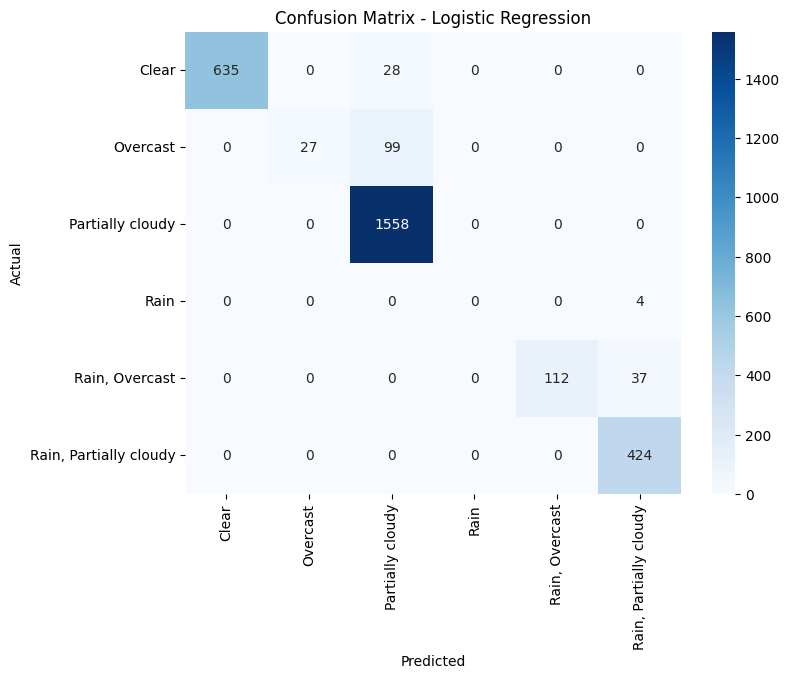

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9985
Partially cloudy : 0.9986
Rain     : 0.9994
Rain, Overcast : 0.9970
Rain, Partially cloudy : 0.9987
Micro-avg : 0.9993


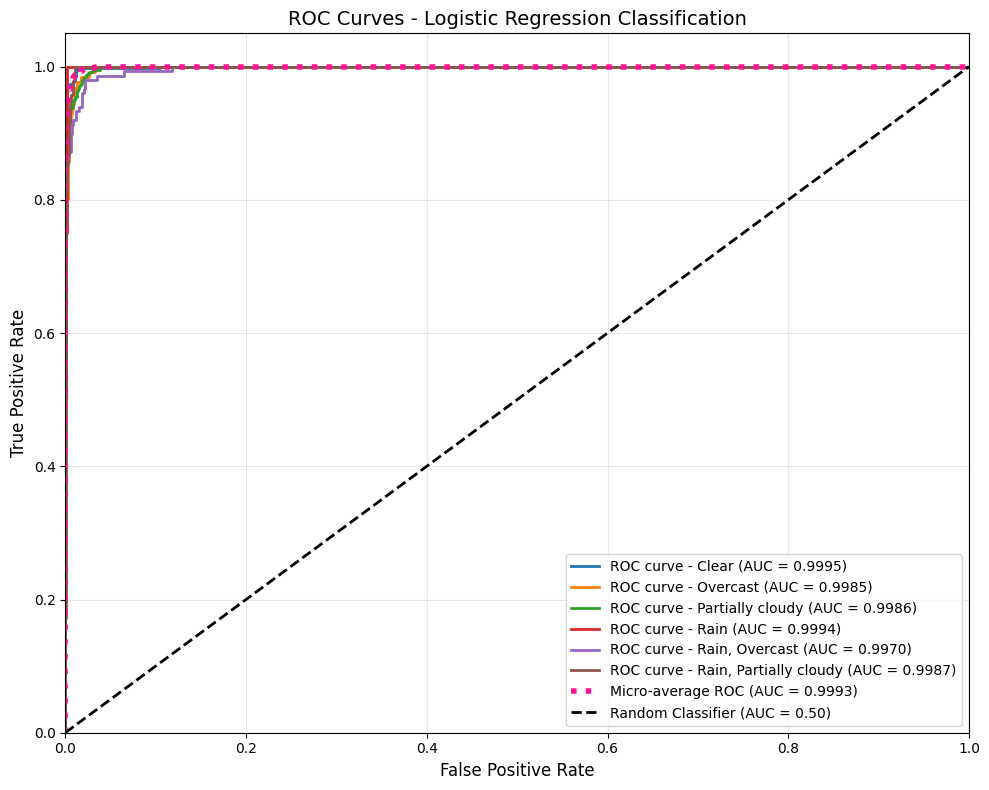

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9987
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9993


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.940492 → 0.942544
   F1-Score: 0.928046 → 0.931080
   AUC (micro-avg): 0.999127 → 0.999324
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [175]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 27.8 s, sys: 4.22 s, total: 32.1 s
Wall time: 1h 18min 25s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best parameters as an array
grid_param_minmax = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.989927200837869


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9870
Precision: 0.9870
Recall:    0.9870
F1-Score:  0.9869


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       0.99      1.00      0.99       424

              accuracy                           0.99      2924
             macro avg       0.94      0.90      0.92      2924
          weighted avg       0.99      0.99      0.99      2924



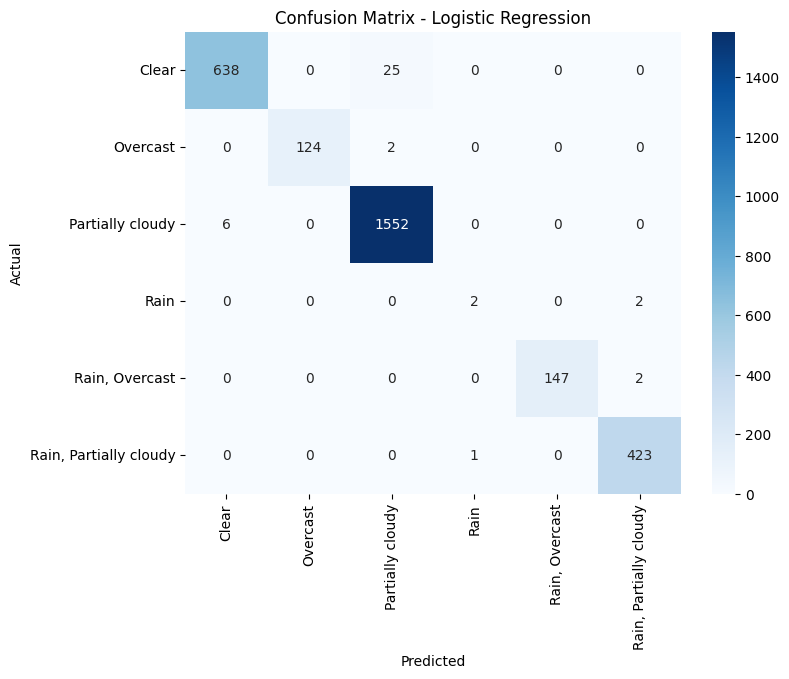

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9954
Partially cloudy : 0.9993
Rain     : 0.9997
Rain, Overcast : 0.9932
Rain, Partially cloudy : 0.9995
Micro-avg : 0.9992


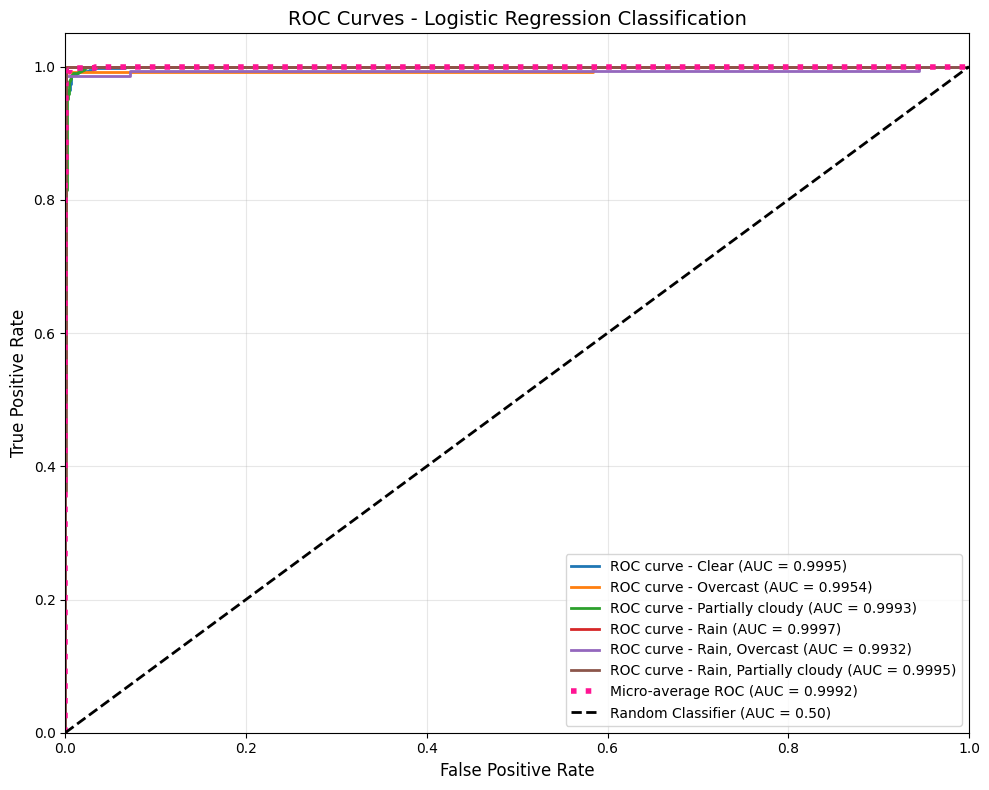

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9980
Micro-average          : 0.9992


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.988030 ≈ 0.987004 (similar)
   F1-Score: 0.987882 ≈ 0.986890 (similar)
   AUC (micro-avg): 0.999221 ≈ 0.999208
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [190]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  5.4min remaining:  5.4min


CPU times: user 1.61 s, sys: 714 ms, total: 2.33 s
Wall time: 6min 16s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.3min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.3s remaining:   32.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.5s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9675
Precision: 0.9687
Recall:    0.9675
F1-Score:  0.9659


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.67      0.81       126
      Partially cloudy       0.96      1.00      0.98      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       1.00      0.87      0.93       149
Rain, Partially cloudy       0.95      1.00      0.97       424

              accuracy                           0.97      2924
             macro avg       0.98      0.79      0.84      2924
          weighted avg       0.97      0.97      0.97      2924



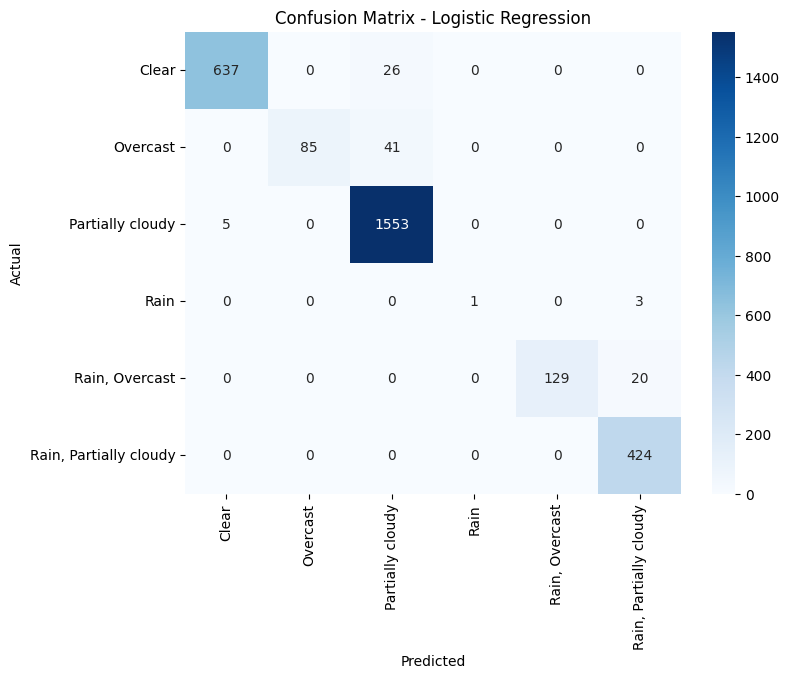

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.9s remaining:   32.9s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.3s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9972
Overcast : 0.9997
Partially cloudy : 0.9971
Rain     : 0.9997
Rain, Overcast : 0.9974
Rain, Partially cloudy : 0.9988
Micro-avg : 0.9975


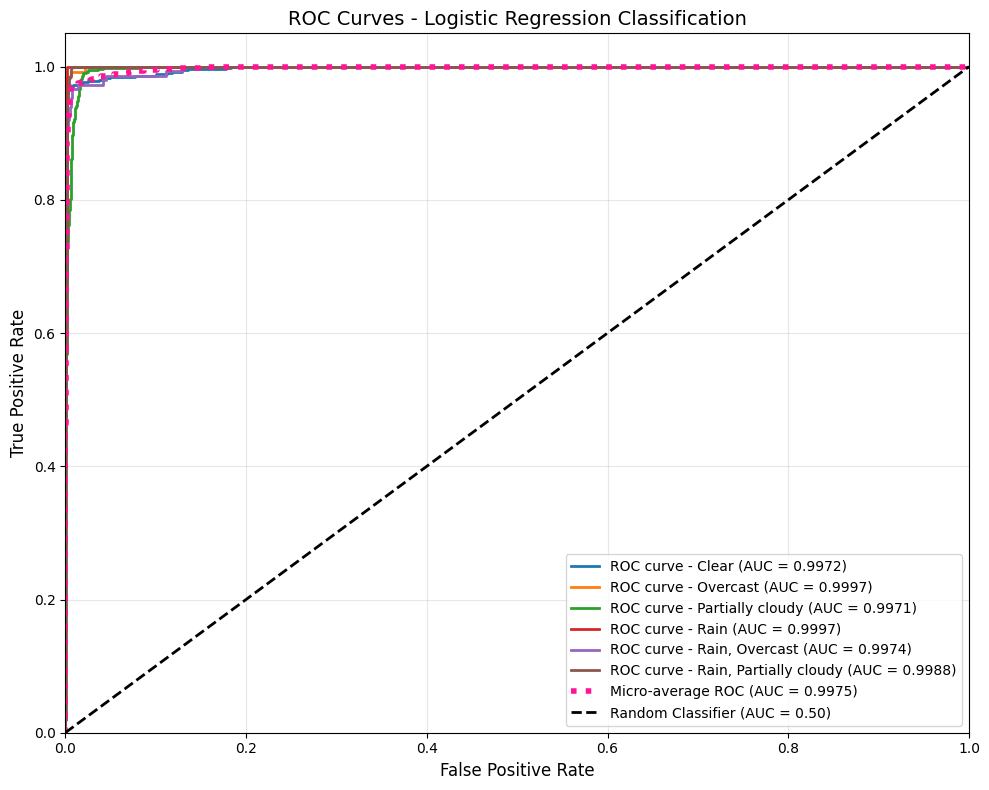

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9975
One-vs-One (Weighted)  : 0.9976
Micro-average          : 0.9975


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.967510, Best Accuracy: 0.976744
   Current F1: 0.965853, Best F1: 0.976238
   Current AUC (micro-avg): 0.997484, Best AUC: 0.998589
   Current Features: 23, Best Features: 27


### Standard Scaler

In [202]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [203]:
X_train

array([[ 1.34459066,  0.64443839,  2.54474033, ..., -0.12811963,
         0.28861286, -0.33504216],
       [-0.53250082,  1.22392493, -0.3929674 , ..., -0.05563671,
        -0.74169989,  3.44763404],
       [ 1.97028782, -1.67350776, -0.3929674 , ..., -0.4982089 ,
        -0.74169989, -0.43437432],
       ...,
       [-0.53250082, -1.67350776, -0.3929674 , ..., -0.86573995,
        -0.74169989, -0.43437432],
       [-0.8453494 , -0.51453468, -0.3929674 , ...,  0.98186394,
        -0.10542524, -0.77398294],
       [-0.8453494 ,  0.49956676,  2.54474033, ...,  0.79539807,
         1.00886284, -0.43437432]])

In [204]:
X_test

array([[-0.8453494 ,  0.06495186, -0.3929674 , ..., -0.86943516,
         2.16513859, -0.43437432],
       [ 1.03174208,  1.65853984, -0.3929674 , ...,  0.99920299,
        -0.74169989, -0.39074871],
       [ 0.09319634,  0.78931003,  2.54474033, ...,  1.00545642,
        -0.07635686,  2.81338475],
       ...,
       [-0.53250082,  1.0790533 , -0.3929674 , ...,  0.98328517,
        -0.74169989, -0.51021577],
       [ 1.03174208,  1.22392493, -0.3929674 , ...,  0.98584339,
        -0.74169989, -0.30416865],
       [-0.53250082, -0.80427795, -0.3929674 , ..., -0.12954086,
        -0.74169989,  5.41145777]])

#### Default Parameters

In [205]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [206]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 8.79 s, sys: 0 ns, total: 8.79 s
Wall time: 8.79 s


SVC(probability=True, random_state=42)

In [207]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [208]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9378
Precision: 0.9414
Recall:    0.9378
F1-Score:  0.9250


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.96      0.98       663
              Overcast       1.00      0.19      0.32       126
      Partially cloudy       0.92      1.00      0.96      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.99      0.69      0.81       149
Rain, Partially cloudy       0.89      1.00      0.94       424

              accuracy                           0.94      2924
             macro avg       0.80      0.64      0.67      2924
          weighted avg       0.94      0.94      0.93      2924



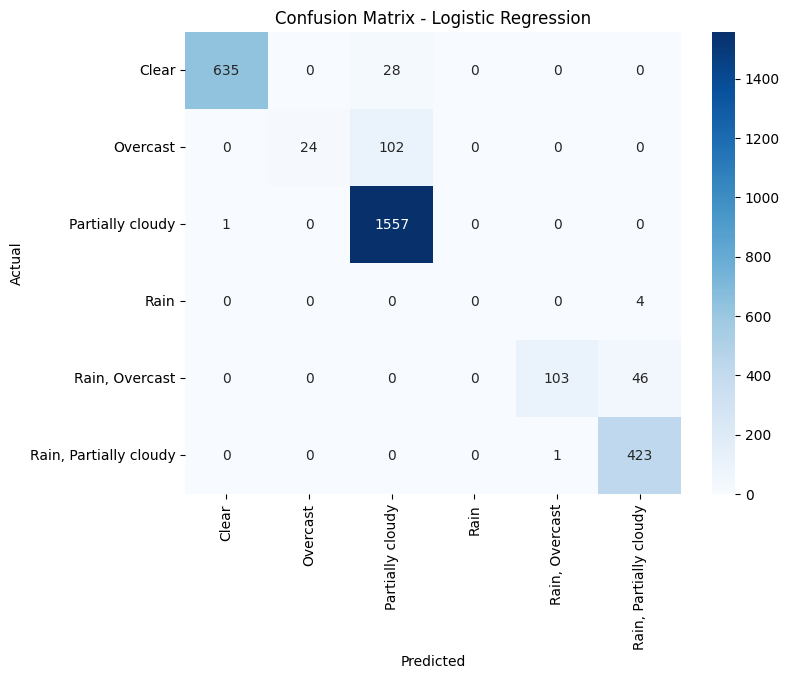

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9994
Overcast : 0.9945
Partially cloudy : 0.9974
Rain     : 0.9985
Rain, Overcast : 0.9946
Rain, Partially cloudy : 0.9976
Micro-avg : 0.9987


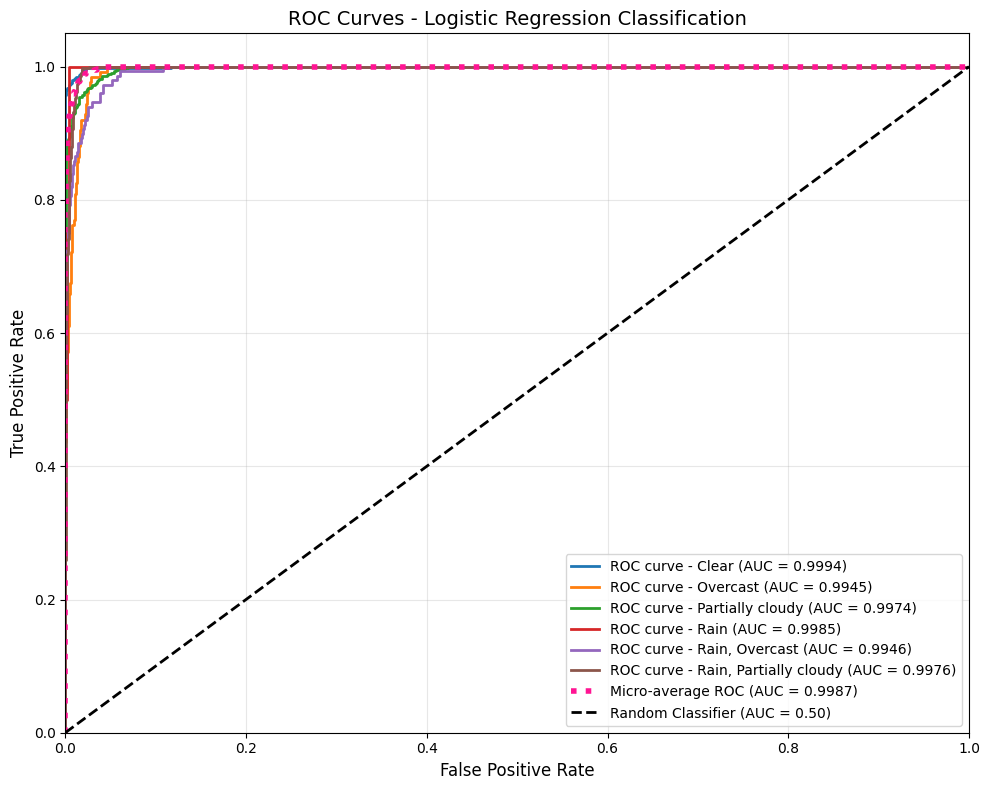

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9976
One-vs-One (Weighted)  : 0.9949
Micro-average          : 0.9987


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.937415 ≈ 0.937756 (similar)
   F1-Score: 0.925080 ≈ 0.925046 (similar)
   AUC (micro-avg): 0.998191 ≈ 0.998670
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [220]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 130 candidates, totalling 650 fits
CPU times: user 31 s, sys: 5.87 s, total: 36.9 s
Wall time: 1h 4min 30s


RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=130, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.1, 1.0],
                                        'gamma': ['scale', 'auto', 0.001, 0.01,
                                                  0.1],
                                        'kernel': ['linear', 'rbf', 'sigmoid'],
                                        'shrinking': [True],
                                        'tol': [0.001, 0.0001]},
                   random_state=42, return_train_score=True,
                   scoring='f1_weighted', verbose=1)

In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to train the robust scaler model
grid_param_standard = {k: [v] for k, v in grid_search.best_params_.items()}

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'tol': 0.0001, 'shrinking': True, 'kernel': 'linear', 'gamma': 'scale', 'coef0': 0.1, 'class_weight': None, 'C': 100}
Best Cross-Validation Score: 0.9901169536112681


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9870
Precision: 0.9870
Recall:    0.9870
F1-Score:  0.9869


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       0.99      1.00      0.99       424

              accuracy                           0.99      2924
             macro avg       0.94      0.90      0.92      2924
          weighted avg       0.99      0.99      0.99      2924



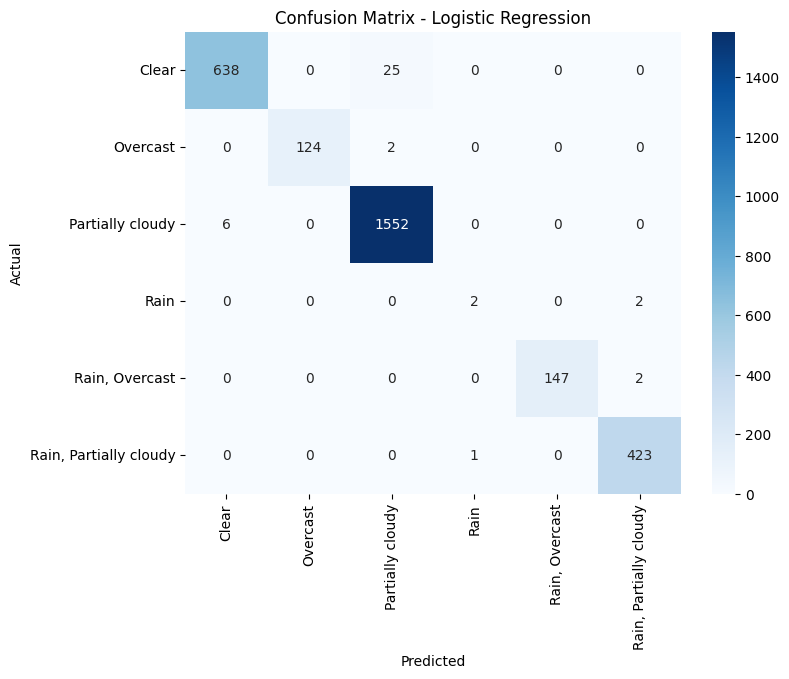

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9953
Partially cloudy : 0.9993
Rain     : 0.9993
Rain, Overcast : 0.9931
Rain, Partially cloudy : 0.9995
Micro-avg : 0.9992


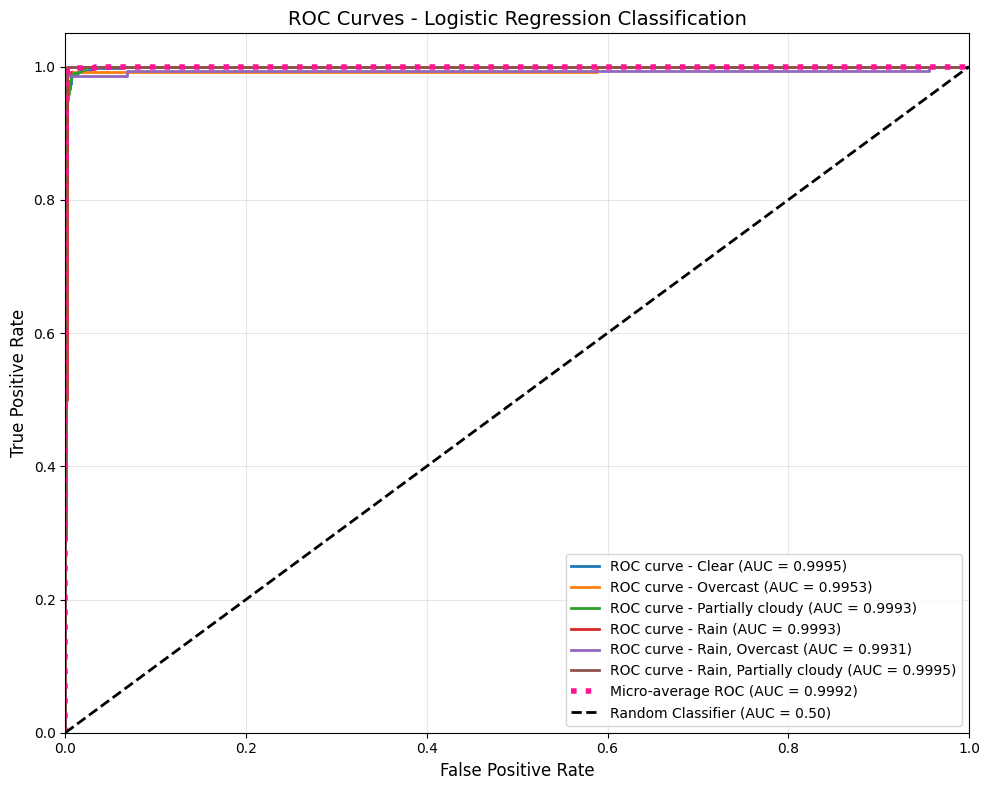

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9989
One-vs-One (Weighted)  : 0.9979
Micro-average          : 0.9992


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': classification_report_dict_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.988030 ≈ 0.987004 (similar)
   F1-Score: 0.987882 ≈ 0.986890 (similar)
   AUC (micro-avg): 0.999295 ≈ 0.999189
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [235]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  5.2min remaining:  5.2min


CPU times: user 1.57 s, sys: 764 ms, total: 2.34 s
Wall time: 6min 8s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.1min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   29.9s remaining:   29.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.1s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9573
Precision: 0.9593
Recall:    0.9573
F1-Score:  0.9540


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.56      0.71       126
      Partially cloudy       0.95      1.00      0.97      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       0.99      0.78      0.87       149
Rain, Partially cloudy       0.92      1.00      0.96       424

              accuracy                           0.96      2924
             macro avg       0.98      0.76      0.82      2924
          weighted avg       0.96      0.96      0.95      2924



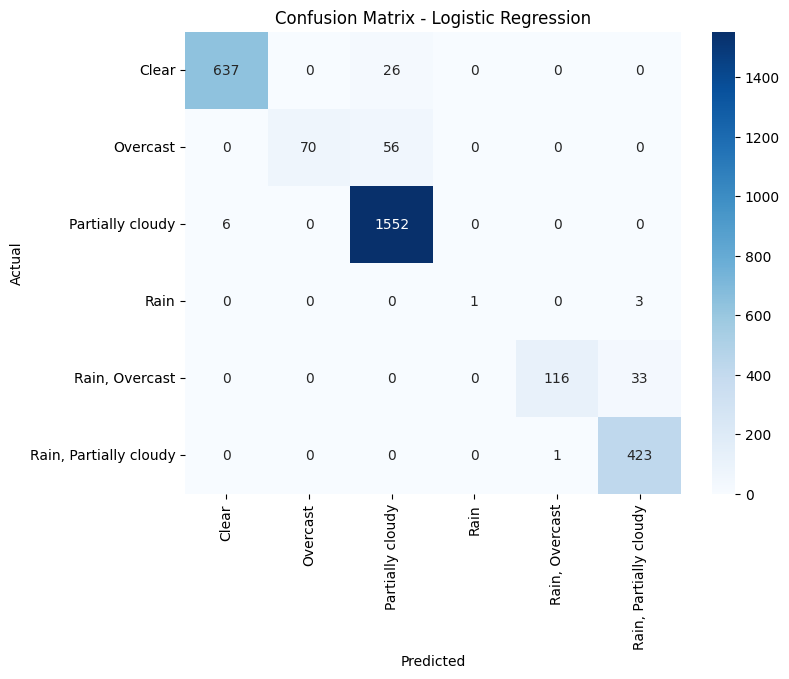

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.6s remaining:   30.6s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.6s finished


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9973
Overcast : 0.9990
Partially cloudy : 0.9964
Rain     : 0.9994
Rain, Overcast : 0.9960
Rain, Partially cloudy : 0.9981
Micro-avg : 0.9969


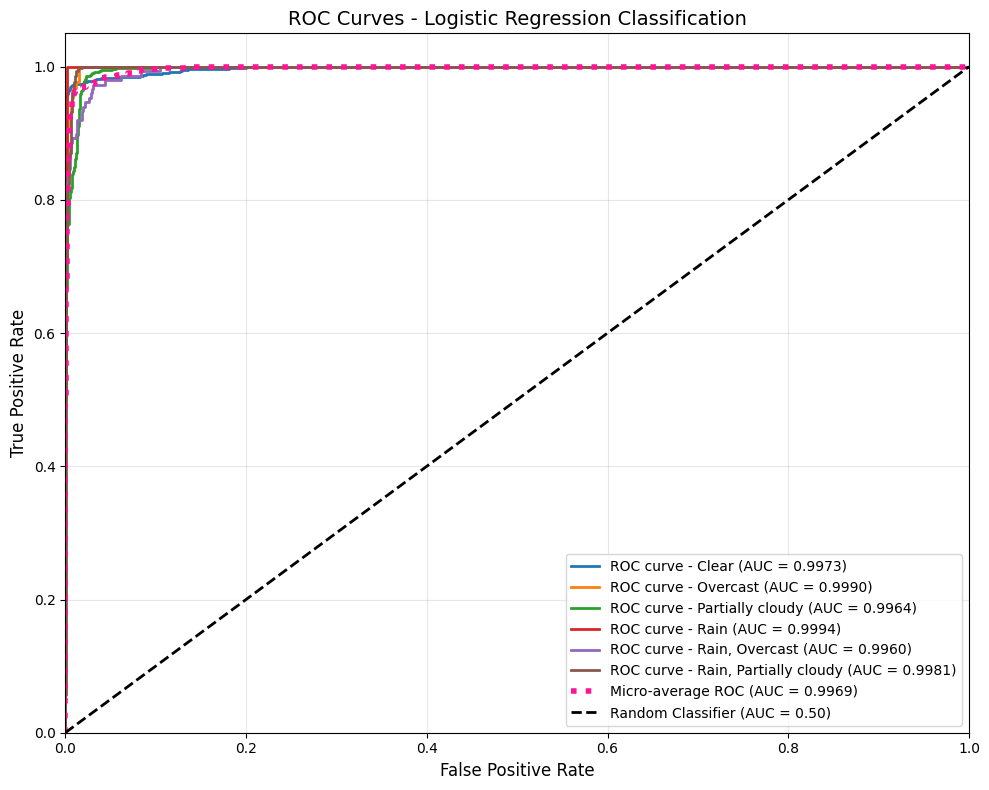

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9969
One-vs-One (Weighted)  : 0.9964
Micro-average          : 0.9969


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.965116 ≈ 0.957250 (similar)
   F1-Score: 0.963414 ≈ 0.954032 (similar)
   AUC (micro-avg): 0.998304 ≈ 0.996915
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


### Robust Scaler

In [247]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [248]:
X_train

array([[ 1.00000000e+00,  3.33333333e-01,  1.00000000e+00, ...,
        -4.07728836e-02,  6.55030801e-01,  5.73643411e-01],
       [-2.00000000e-01,  6.66666667e-01,  0.00000000e+00, ...,
         9.82479122e-04,  0.00000000e+00,  2.24186047e+01],
       [ 1.40000000e+00, -1.00000000e+00,  0.00000000e+00, ...,
        -2.53970853e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-2.00000000e-01, -1.00000000e+00,  0.00000000e+00, ...,
        -4.65695104e-01,  0.00000000e+00,  0.00000000e+00],
       [-4.00000000e-01, -3.33333333e-01,  0.00000000e+00, ...,
         5.98657279e-01,  4.04517454e-01, -1.96124031e+00],
       [-4.00000000e-01,  2.50000000e-01,  1.00000000e+00, ...,
         4.91239561e-01,  1.11293634e+00,  0.00000000e+00]])

In [249]:
X_test

array([[-0.4       ,  0.        ,  0.        , ..., -0.46782381,
         1.84804928,  0.        ],
       [ 0.8       ,  0.91666667,  0.        , ...,  0.60864582,
         0.        ,  0.25193798],
       [ 0.2       ,  0.41666667,  1.        , ...,  0.61224824,
         0.42299795, 18.75581395],
       ...,
       [-0.2       ,  0.58333333,  0.        , ...,  0.59947601,
         0.        , -0.4379845 ],
       [ 0.8       ,  0.66666667,  0.        , ...,  0.60094973,
         0.        ,  0.75193798],
       [-0.2       , -0.5       ,  0.        , ..., -0.04159162,
         0.        , 33.75968992]])

#### Default Parameters

In [250]:
training_model = SVC(random_state=42, probability=True)
training_model

SVC(probability=True, random_state=42)

In [251]:
%%time
training_model.fit(X_train, y_train)

CPU times: user 22.6 s, sys: 551 ms, total: 23.1 s
Wall time: 23.1 s


SVC(probability=True, random_state=42)

In [252]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      dtype=object)

In [253]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.6823
Precision: 0.7149
Recall:    0.6823
F1-Score:  0.5671


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.02      0.04       663
              Overcast       0.00      0.00      0.00       126
      Partially cloudy       0.67      1.00      0.80      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.47      0.10      0.17       149
Rain, Partially cloudy       0.75      0.96      0.84       424

              accuracy                           0.68      2924
             macro avg       0.48      0.35      0.31      2924
          weighted avg       0.71      0.68      0.57      2924



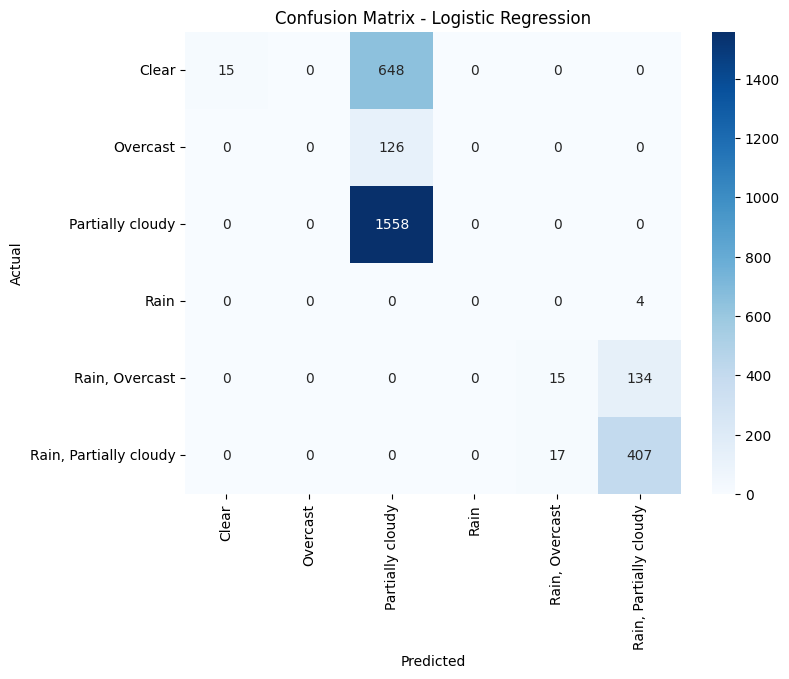

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9743
Overcast : 0.9987
Partially cloudy : 0.9767
Rain     : 0.9968
Rain, Overcast : 0.9736
Rain, Partially cloudy : 0.9743
Micro-avg : 0.9870


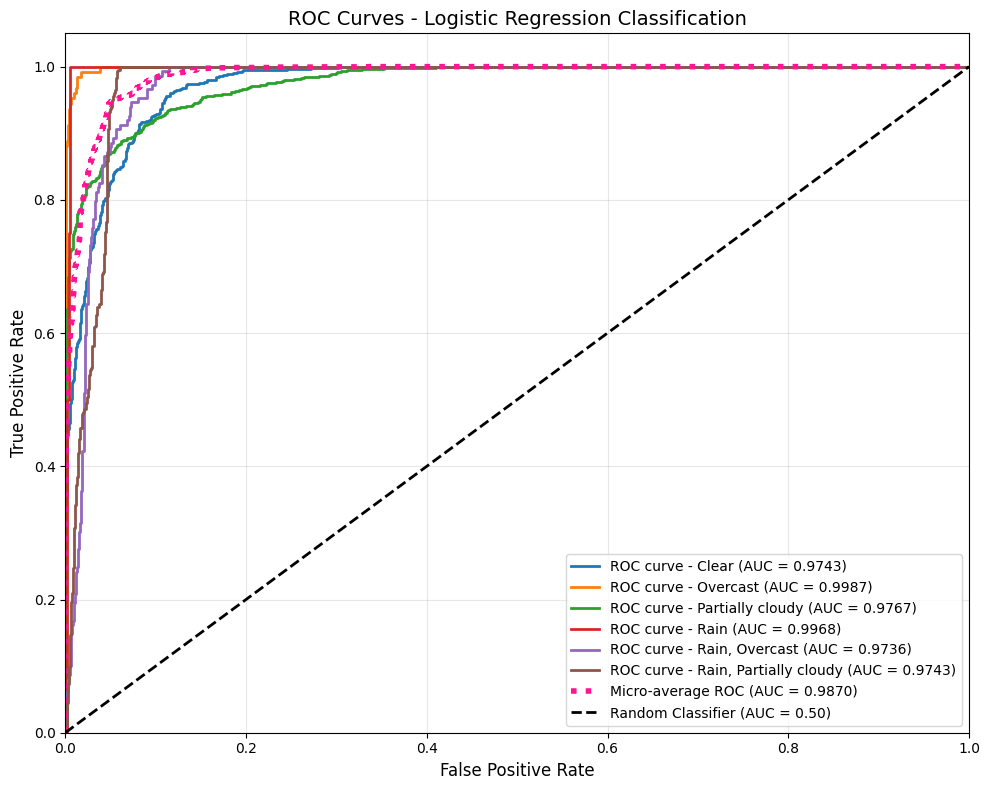

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9766
One-vs-One (Weighted)  : 0.9654
Micro-average          : 0.9870


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.682285, Best Accuracy: 0.686047
   Current F1: 0.567104, Best F1: 0.575394
   Current AUC (micro-avg): 0.987023, Best AUC: 0.987153
   Current Features: 23, Best Features: 27


#### Tuning with Grid Search

In [264]:
grid_param_robust = [grid_param_minmax, grid_param_standard]

In [265]:
grid_search = GridSearchCV(
    SVC(random_state=42, probability=True), 
    grid_param_robust,
    cv=5, 
    scoring='f1_weighted', 
    n_jobs=-1, # allow parallel processing, you cant use your own laptop while this runs
    verbose=1,
    return_train_score=True
)

grid_search

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [266]:
%%time
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

Starting Grid Search...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: user 22min 58s, sys: 6.61 s, total: 23min 5s
Wall time: 2h 5min 40s


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]},
                         {'C': [100], 'class_weight': [None], 'coef0': [0.1],
                          'gamma': ['scale'], 'kernel': ['linear'],
                          'shrinking': [True], 'tol': [0.0001]}],
             return_train_score=True, scoring='f1_weighted', verbose=1)

In [267]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'C': 100, 'class_weight': None, 'coef0': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True, 'tol': 0.0001}
Best Cross-Validation Score: 0.9886492948927612


In [268]:
y_pred_grid = best_grid_model.predict(X_test)

In [269]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [270]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9856
Precision: 0.9856
Recall:    0.9856
F1-Score:  0.9855


In [271]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.96      0.98       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.98      1.00      0.99      1558
                  Rain       0.67      0.50      0.57         4
        Rain, Overcast       0.99      0.97      0.98       149
Rain, Partially cloudy       0.99      1.00      0.99       424

              accuracy                           0.99      2924
             macro avg       0.94      0.90      0.92      2924
          weighted avg       0.99      0.99      0.99      2924



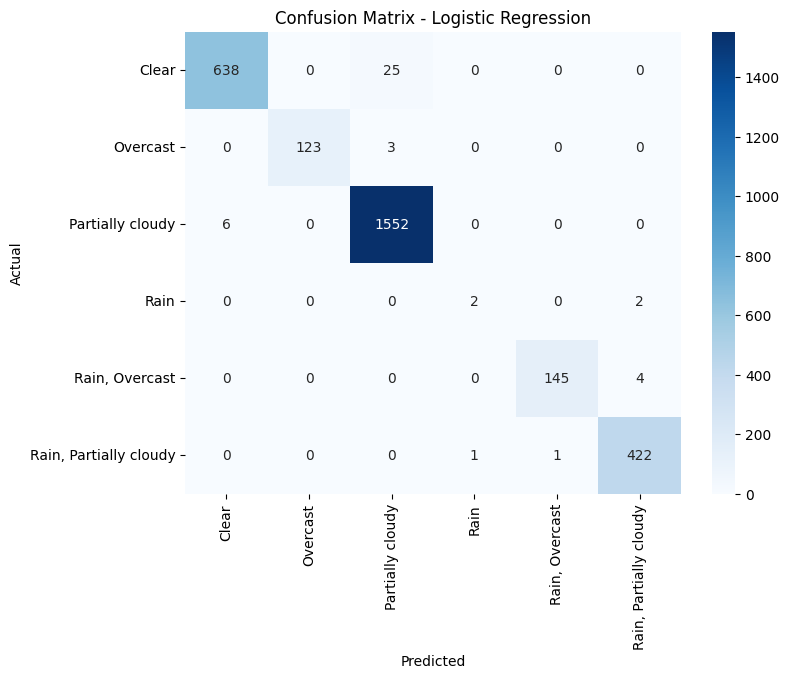

In [272]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [273]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [274]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [275]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9995
Overcast : 0.9955
Partially cloudy : 0.9993
Rain     : 0.9993
Rain, Overcast : 0.9873
Rain, Partially cloudy : 0.9994
Micro-avg : 0.9989


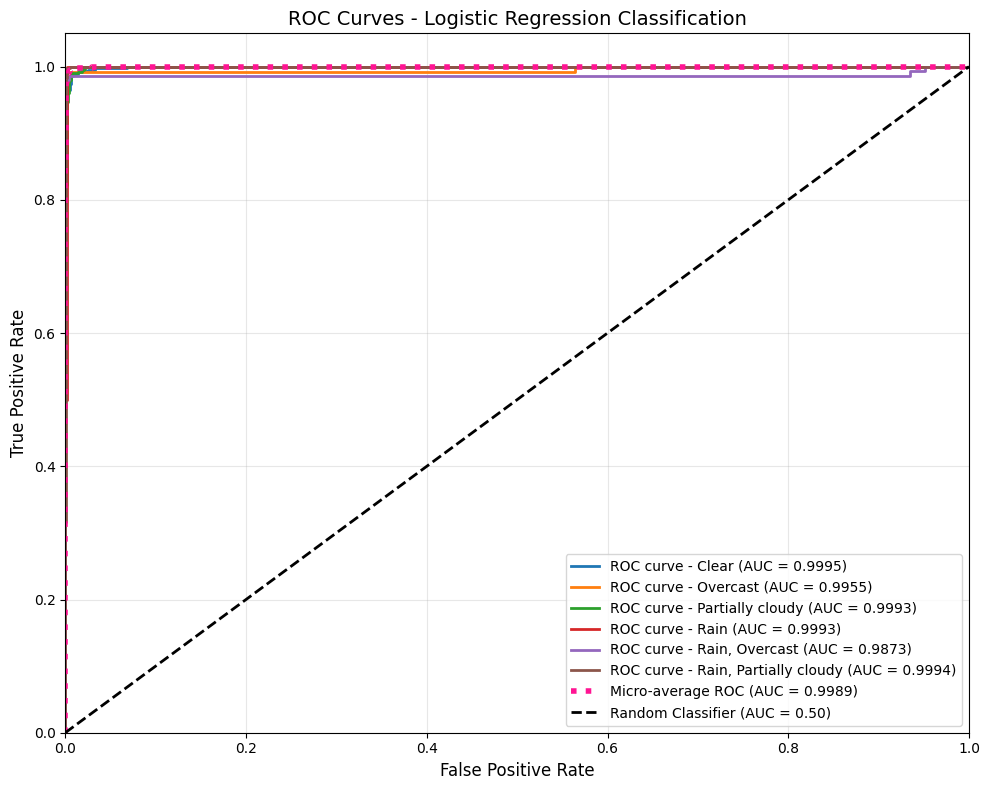

In [276]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [277]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9986
One-vs-One (Weighted)  : 0.9972
Micro-average          : 0.9989


In [278]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': classification_report_dict_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.985978 ≈ 0.985636 (similar)
   F1-Score: 0.985817 ≈ 0.985518 (similar)
   AUC (micro-avg): 0.998376 ≈ 0.998878
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [279]:
base_model = SVC(random_state=42, probability=True)
base_model

SVC(probability=True, random_state=42)

In [280]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [281]:
%%time
print("Starting Bagging Ensamble...")
bagging_clf.fit(X_train, y_train)

Starting Bagging Ensamble...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  6.3min remaining:  6.3min


CPU times: user 2.19 s, sys: 338 ms, total: 2.53 s
Wall time: 6min 39s


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  6.7min finished


BaggingClassifier(bootstrap_features=True,
                  estimator=SVC(probability=True, random_state=42),
                  max_features=0.8, n_estimators=100, n_jobs=-1,
                  random_state=42, verbose=1)

In [282]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   41.2s remaining:   41.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   42.5s finished


In [283]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [284]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.8930
Precision: 0.9016
Recall:    0.8930
F1-Score:  0.8780


In [285]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.90      0.90      0.90       663
              Overcast       1.00      0.58      0.73       126
      Partially cloudy       0.93      0.96      0.94      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       0.96      0.16      0.28       149
Rain, Partially cloudy       0.76      1.00      0.87       424

              accuracy                           0.89      2924
             macro avg       0.76      0.60      0.62      2924
          weighted avg       0.90      0.89      0.88      2924



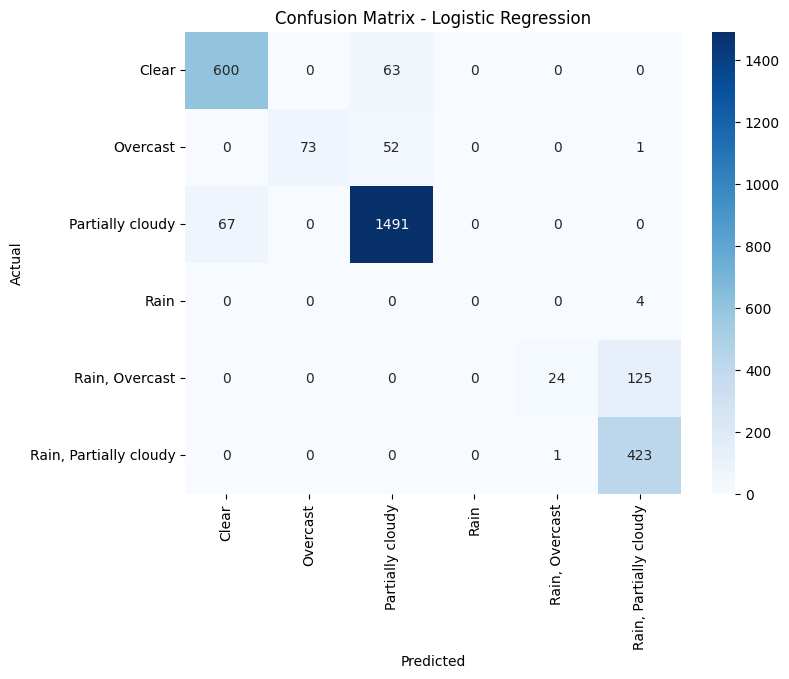

In [286]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [287]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   41.4s remaining:   41.4s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   42.9s finished


In [288]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [289]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9881
Overcast : 0.9997
Partially cloudy : 0.9866
Rain     : 0.9998
Rain, Overcast : 0.9859
Rain, Partially cloudy : 0.9924
Micro-avg : 0.9920


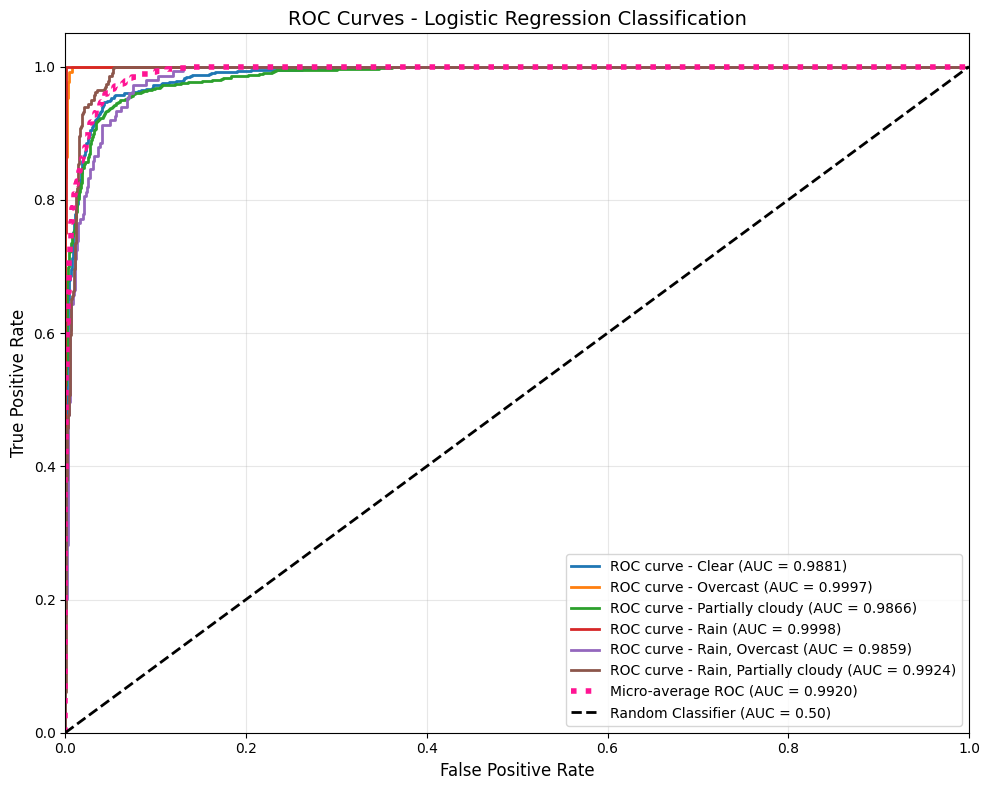

In [290]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [291]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9883
One-vs-One (Weighted)  : 0.9879
Micro-average          : 0.9920


In [292]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.892955, Best Accuracy: 0.916553
   Current F1: 0.877999, Best F1: 0.905096
   Current AUC (micro-avg): 0.991988, Best AUC: 0.995382
   Current Features: 23, Best Features: 27


# All Performance

In [293]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
      Model         Scaler     Target  Features Accuracy Precision   Recall F1-Score
   SVC Grid   MinMaxScaler Conditions        23 0.987004  0.986962 0.987004 0.986890
   SVC Grid StandardScaler Conditions        23 0.987004  0.986962 0.987004 0.986890
   SVC Grid   RobustScaler Conditions        23 0.985636  0.985607 0.985636 0.985518
SVC Bagging   MinMaxScaler Conditions        27 0.976744  0.977281 0.976744 0.976238
SVC Bagging StandardScaler Conditions        23 0.957250  0.959336 0.957250 0.954032
        SVC   MinMaxScaler Conditions        23 0.942544  0.945686 0.942544 0.931080
        SVC StandardScaler Conditions        23 0.937756  0.941397 0.937756 0.925046
SVC Bagging   RobustScaler Conditions        27 0.916553  0.922922 0.916553 0.905096
        SVC   RobustScaler Conditions        27 0.686047  0.716590 0.686047 0.575394

📈 Total models shown: 9
🏆 Best F1-Score: 0.986890 (SVC Grid + MinMaxScaler for Conditions)


# <center><font size="50" color="red">Thank You</font></center>